In [1]:
import time
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import hoomd
import hoomd.md
import hoomd.md.integrate

import gsd
import gsd.hoomd

import polykit.generators.initial_conformations 

In [2]:
# setup the output folder with separate trajectory files for 
# the initial configuration, the optimized configuration, and the trajectory

OUT_ROOT_FOLDER = pathlib.Path('./example_traj/')
os.makedirs(OUT_ROOT_FOLDER, exist_ok=True)    

OUT_INIT_PATH = OUT_ROOT_FOLDER/'init.gsd'
OUT_OPTIMIZED_PATH = OUT_ROOT_FOLDER/'optimized.gsd'
OUT_TRAJ_PATH = OUT_ROOT_FOLDER/'traj.gsd'

In [3]:
# The first key step of the simulation is to define its configuration, namely:
# (a) the number, types and initial positions of the particles,
# (b) the topological information, i.e. bonds, angles, dihedral angles,
# (c) the box size for the periodic boundary conditions.

L_CHAIN = 40
N_CHAINS = 100
N_PARTICLES = L_CHAIN * N_CHAINS
DENSITY = 0.2

# The gsd.hoomd.Frame() object represents a snapshot or frame of a simulation in the HOOMD-blue package. 
# It contains information about the state of the system at a specific point in time. 
# This includes the positions, types, and other properties of the particles in the simulation, 
# as well as bonds, angles, and dihedrals, and the box size and other simulation parameters.
init_snapshot = gsd.hoomd.Frame()

# Initialize particles
init_snapshot.particles.N = N_PARTICLES
init_snapshot.particles.types = ["CHROMATIN"]
typeids = np.zeros(N_PARTICLES, dtype=np.int32)
init_snapshot.particles.typeid = typeids

# Periodic boundary conditions set by density
BOX_SIZE = (N_PARTICLES / DENSITY) ** (1 / 3.0)
init_snapshot.configuration.box = [BOX_SIZE, BOX_SIZE, BOX_SIZE, 0, 0, 0]

# Create initial conformation. Note that initial particles positions cannot lie outside the box.
init_positions = polykit.generators.initial_conformations.grow_cubic(N=N_PARTICLES, boxSize=int(BOX_SIZE - 1)).astype(float)
# center in the box
init_positions -= init_positions.mean(axis=0, keepdims=True)

# Alternatively, we can use to initialize particle positions with a random walk constrained to the box.
# init_positions = polykit.generators.initial_conformations.create_constrained_random_walk(
#     N_PARTICLES,
#     constraint_f=lambda x: all(np.abs(x[i]) < BOX_SIZE // 2 for i in range(3)),
# )


# Set the initial positions of the particles.
init_snapshot.particles.position = init_positions

In [4]:
# Initialize bonds
def get_polymer_bonds(lo, hi, ring=False):
    bonds = np.vstack([np.arange(lo, hi-1), np.arange(lo+1, hi)]).T
    return bonds

polymer_bonds = np.zeros((0,2)).astype(int)
for i in range(N_CHAINS):
    lo = int(i * L_CHAIN)
    hi = int((i+1) * L_CHAIN)
    polymer_bonds = np.vstack((polymer_bonds, get_polymer_bonds(lo, hi, ring=False)))

init_snapshot.bonds.N = polymer_bonds.shape[0] 
init_snapshot.bonds.types = ['polymer']
init_snapshot.bonds.typeid = np.zeros(polymer_bonds.shape[0])
init_snapshot.bonds.group = polymer_bonds
init_snapshot.bonds.validate()

In [5]:
# Once we configure particles, box and topological information, we save the system state into a file.
with gsd.hoomd.open(name=OUT_INIT_PATH, mode='w') as f:
    f.append(init_snapshot)

In [6]:
# The system state (aka a "snapshot") defined above is then used to initialize a HOOMD-blue simulation.
try:
    current_device = hoomd.device.GPU()
    print(current_device.get_available_devices(), current_device.is_available())
except:
    current_device = hoomd.device.CPU()
    print('No GPU found, using CPU')

sim = hoomd.Simulation(device=current_device, seed=1)

sim.create_state_from_gsd(filename=OUT_INIT_PATH)

['[0]  Tesla P100-PCIE-12GB  56 SM_6.0 @ 1.33 GHz, 12193 MiB DRAM'] True


In [7]:
# The second key step of setting up a simulation is to define the forces that act on the particles (i.e. a Hamiltonian).

# first, add bonded forces. 
bonded_forces = hoomd.md.bond.FENEWCA()
bonded_forces.params.default = dict(
    k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0
)
# parametes can also be specified for specific bond types: 
# bonded_forces.params['polymer'] = dict(k=30.0, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)


# add nonbonded forces.
# nonbonded forces are defined by a neighbor list, which is a data structure that computes and stores 
# the list of particles that are within a certain distance of each other.
nlist = hoomd.md.nlist.Cell(buffer=0.4, exclusions=("bond",))

nonbonded_forces = hoomd.md.pair.LJ(nlist=nlist, default_r_cut=1.122462048309373)
nonbonded_forces.params[("CHROMATIN", "CHROMATIN")] = {"epsilon": 1.0, "sigma": 1.0}


In [8]:
# perform inital energy minimization with FIRE (fast internal relaxation engine).
# This helps to remove any overlaps between particles and to relax the initial configuration 
# to avoid large forces that can cause the simulation to crash.

DT_FIRE = 0.0005

# The integrator is the object that applies forces and a thermostat to the particles, and updates their positions and velocities.
fire = hoomd.md.minimize.FIRE(
    dt=DT_FIRE,
    force_tol=5e-2,
    angmom_tol=5e-2,
    energy_tol=5e-2)

# Forces are then attached to the integrator 
fire.forces = [bonded_forces, nonbonded_forces]

# Methods describe the thermostat and barostat that are applied to the system, e.g. Langevin or Brownian dynamics.
# For FIRE, we use a constant volume method, which simply updates the positions of the particles. 
fire.methods = [hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All())]
# note: we can selectitvely update the positions of a subset of particles by using filters:
# filter = hoomd.filter.Type(['CHROMATIN'])

sim.operations.integrator = fire

In [9]:
N_FIRE_BLOCKS = 10
N_FIRE_STEPS = 1000

# writing is perfomed by the gsd writer object, which saves system states (i.e. snapshots) to a file at regular intervals.
# These regular intervals are defined by the trigger argument of the writer. Triggers can occur within simulation blocks. 
gsd_optimized_writer = hoomd.write.GSD(
    filename=OUT_OPTIMIZED_PATH,
    trigger=hoomd.trigger.Periodic(N_FIRE_STEPS),
    mode='wb')
sim.operations.writers.append(gsd_optimized_writer)

# hoomd can compute and log thermodynamic properties of the system, such as temperature, pressure, and energy: 
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
sim.operations.computes.append(thermodynamic_properties)

# we need to run the simulation (even if for 0 steps) to apply the forces and compute the thermodynamic properties
sim.run(0)
print(f'kin temp = {thermodynamic_properties.kinetic_temperature:.3g}, '
      f'E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES:.3g}')

for i in range(N_FIRE_BLOCKS):
    sim.run(N_FIRE_STEPS)
    print(f'FIRE block #{i+1} / {N_FIRE_BLOCKS}, '
          f'kin temp = {thermodynamic_properties.kinetic_temperature:.3g}, '
          f'E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES:.3g}' )
    gsd_optimized_writer.write(sim.state, gsd_optimized_writer.filename)

# remove the forces and writers from the integrator
# so that they can be attached to the new integrator
for _ in range(len(fire.forces)):
    fire.forces.pop()
sim.operations.writers.pop(0)

# FIRE reduces the kinetic energy of particles, so we need to re-thermalize the system
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)


kin temp = 0, E_P/N = 20.3
block #1 / 10, kin temp = 0.0216, E_P/N = 18.8
block #2 / 10, kin temp = 0.0241, E_P/N = 19.3
block #3 / 10, kin temp = 2.86e-06, E_P/N = 19.6
block #4 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #5 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #6 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #7 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #8 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #9 / 10, kin temp = 8.78e-06, E_P/N = 19.6
block #10 / 10, kin temp = 8.78e-06, E_P/N = 19.6


In [10]:
# setup LANGEVIN dynamics

# langevin integrator parameters
NUM_BLOCKS = 100
BLOCK_SIZE = 10000
LANGEVIN_TIMESTEP = 0.01

# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)

run_integrator = hoomd.md.Integrator(
    dt=LANGEVIN_TIMESTEP, 
    methods=[langevin], 
    forces=[bonded_forces, nonbonded_forces])
sim.operations.integrator = run_integrator

gsd_writer = hoomd.write.GSD(
    filename=OUT_TRAJ_PATH,
    trigger=hoomd.trigger.Periodic(BLOCK_SIZE),
    dynamic=['property','momentum'],
    mode='wb')

sim.operations.writers.append(gsd_writer)


In [11]:
# run langevin dynamics

for i in range(0, NUM_BLOCKS):
    start=time.time()
    sim.run(BLOCK_SIZE)
    print(f'block #{i+1} / {N_FIRE_BLOCKS}, '
          f'kin temp = {thermodynamic_properties.kinetic_temperature:.3g}, '
          f'E_P/N = {thermodynamic_properties.potential_energy / N_PARTICLES:.3g}' )

block #1 / 10, kin temp = 1, E_P/N = 20.2
block #2 / 10, kin temp = 0.988, E_P/N = 20.2
block #3 / 10, kin temp = 1, E_P/N = 20.2
block #4 / 10, kin temp = 1.01, E_P/N = 20.2
block #5 / 10, kin temp = 0.992, E_P/N = 20.1
block #6 / 10, kin temp = 1.02, E_P/N = 20.2
block #7 / 10, kin temp = 1.01, E_P/N = 20.2
block #8 / 10, kin temp = 1, E_P/N = 20.2
block #9 / 10, kin temp = 0.991, E_P/N = 20.1
block #10 / 10, kin temp = 1, E_P/N = 20.2
block #11 / 10, kin temp = 0.98, E_P/N = 20.2
block #12 / 10, kin temp = 1.02, E_P/N = 20.2
block #13 / 10, kin temp = 0.989, E_P/N = 20.2
block #14 / 10, kin temp = 0.992, E_P/N = 20.1
block #15 / 10, kin temp = 1, E_P/N = 20.2
block #16 / 10, kin temp = 0.98, E_P/N = 20.2
block #17 / 10, kin temp = 1, E_P/N = 20.1
block #18 / 10, kin temp = 0.977, E_P/N = 20.2
block #19 / 10, kin temp = 1.01, E_P/N = 20.2
block #20 / 10, kin temp = 1.01, E_P/N = 20.2
block #21 / 10, kin temp = 1.01, E_P/N = 20.2
block #22 / 10, kin temp = 0.986, E_P/N = 20.1
block #2

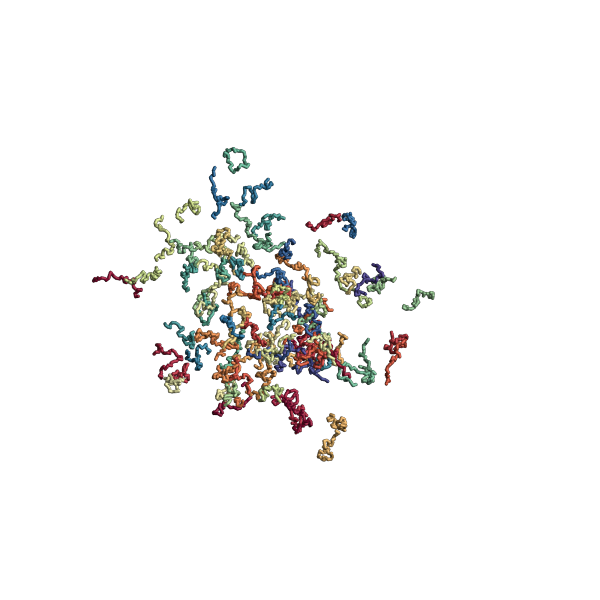

In [12]:
import polychrom_hoomd.render as render
snapshot_relaxed= sim.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="Spectral").static(pathtrace=False)

